# LGBM Prefit with NN
* Based on https://www.kaggle.com/code/enricomanosperti/regression-with-a-mohs-hardness-dataset
* Interesting that this increases public lb score, but my feel is that it will overfit on private lb.


In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import median_absolute_error
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import tensorflow_probability as tfp


In [2]:
class Config():
    seed = 12
    folds = 5
    
config=Config()

In [3]:
train = pd.read_csv("/kaggle/input/playground-series-s3e25/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s3e25/test.csv")
ss = pd.read_csv('/kaggle/input/playground-series-s3e25/sample_submission.csv')

In [4]:
features = [col for col in train.columns if 'id' not in col]

In [5]:
X = train[features].drop(columns='Hardness')
y = train.Hardness

In [6]:
model_lgbm = LGBMRegressor(objective='mae',
                        learning_rate=.15,
                        min_child_samples=50,
                        random_state=config.seed)
model_lgbm.fit(X,y)
X_new = X.copy()
X_new['Hardness_pred'] = model_lgbm.predict(X)

In [7]:
def loss_fn(y_true, y_pred):
    return tfp.stats.percentile(tf.abs(y_true - y_pred), q=50)
def metric_fn(y_true, y_pred):
    return tfp.stats.percentile(tf.abs(y_true - y_pred), q=100) - tfp.stats.percentile(tf.abs(y_true - y_pred), q=0)

In [8]:
callbacks_list = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, verbose=2, mode='min',restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, min_lr=0.00001),
    tf.keras.callbacks.TerminateOnNaN()
] 

In [9]:
def createModel():
    nnmodel = tf.keras.models.Sequential()
    nnmodel.add(tf.keras.layers.InputLayer(input_shape=(12,)))
    nnmodel.add(tf.keras.layers.BatchNormalization(epsilon=0.00001))
    nnmodel.add(tf.keras.layers.Dense(32, activation='relu'))
    nnmodel.add(tf.keras.layers.Dense(64, activation='relu'))
    nnmodel.add(tf.keras.layers.Dense(1))
    nnmodel.compile(optimizer=tf.keras.optimizers.Adam(0.013, beta_1=0.5),loss=loss_fn,metrics=metric_fn)
    return nnmodel

In [10]:
model_nn = createModel()
model_nn.summary()
history = model_nn.fit(X_new.astype('float32'), y.astype('float32'),
                    epochs=100,
                    class_weight=model_lgbm.class_weight,
                    callbacks=callbacks_list,
                    validation_split=0.2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 12)                48        
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 32)                416       
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2641 (10.32 KB)
Trainable params: 2617 (10.22 KB)
Non-trainable params: 24 (96.00 Byte)
_________________________________________________________________
Epoch 1/100
261/261 [==============================] - 3s 4ms/step - loss: 1.4696 - me

In [11]:
test['Hardness_pred'] = model_lgbm.predict(test.astype('float32').drop(columns='id'))
ss["Hardness"] = model_nn.predict(test.astype('float32').drop(columns='id'))
#ss = test[['id', "Hardness"]]
#ss.Hardness = test['Hardness']
ss.to_csv("submission.csv", index=False)

217/217 [==============================] - 0s 1ms/step


In [12]:
test.head()

,id,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness_pred
0,10407,884.0,121.420000,35.36,5.28,82.561240,9.370384,2.298,1.9072,1.200000,0.461899,1.79459,2.846999
1,10408,90.0,9.931960,18.00,5.60,39.568056,12.086300,2.868,1.6520,0.864000,0.476196,1.41194,2.509377
2,10409,116.0,7.767992,11.60,4.80,23.231818,11.023840,2.644,1.7940,0.960000,0.499514,0.78834,5.989584
3,10410,100.0,9.107996,10.00,4.80,20.298893,12.086300,2.828,1.6620,0.792000,0.495796,1.20466,4.191429
4,10411,55.0,4.030000,11.00,4.00,22.977675,11.280950,2.455,1.7500,0.893333,0.476095,0.93456,5.282616


In [13]:
ss.head()

,id,Hardness
0,10407,2.575260
1,10408,2.351657
2,10409,5.815323
3,10410,3.819762
4,10411,5.726339


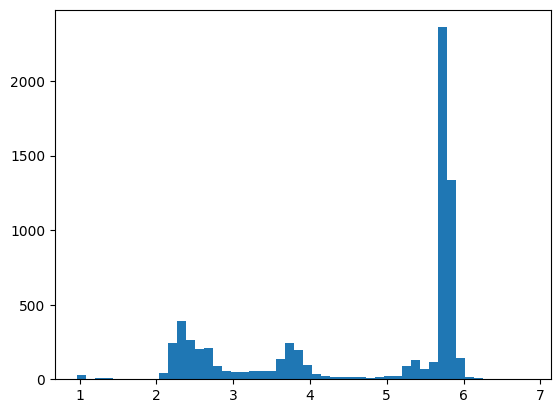

In [14]:
plt.hist(ss.Hardness,bins=50)
plt.show()